In [67]:
import pandas as pd
import numpy as np
from time import perf_counter 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [68]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Baseline with RNN

In [69]:
train = pd.read_csv('dialect-identification/data/all/train_prepro.csv')
test = pd.read_csv('dialect-identification/data/all/test_prepro.csv')

train.columns = ['text', 'variety', 'group']
test.columns = ['text', 'variety', 'group']
train = train.drop(columns=['group'])
test = test.drop(columns=['group'])

sets = [train, test]

l_enc = LabelEncoder()

for set in sets:
    set['variety_encoded'] = l_enc.fit_transform(set['variety'])

In [70]:
train.variety_encoded.value_counts()

variety_encoded
6     18922
9     18859
10    18854
8     18754
11    18723
5     18564
4     18512
7     16723
3      3870
0      3750
2      3390
1      3269
Name: count, dtype: int64

In [71]:
train, val = train_test_split(train, test_size=0.2, random_state=42)

train_text = tf.constant(train['text'].values)
train_label = tf.constant(train['variety_encoded'].values, dtype=tf.int64)

val_text = tf.constant(val['text'].values)
val_label = tf.constant(val['variety_encoded'].values, dtype=tf.int64)

test_text = tf.constant(test['text'].values)
test_label = tf.constant(test['variety_encoded'].values, dtype=tf.int64)


train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_label))

In [72]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [73]:
vocab_size = len(np.unique(np.hstack(train['text'].values)))
vocab_size


129652

In [74]:
VOCAB_SIZE = 100000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

## Model: biLSTM

In [75]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [76]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [77]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(1e-4),
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          6400000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 12)                780       
                                                                 
Total params: 6475084 (24.70 MB)
Trainable params: 647

## Training the model

In [79]:
VAL_STEPS = test.shape[0] // BATCH_SIZE
print(VAL_STEPS)

314


In [80]:
EPOCHS = 15
history = model.fit(train_dataset, epochs=EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=VAL_STEPS)

Epoch 1/15
2028/2028 [==============================] - 174s 84ms/step - loss: 1.1760 - accuracy: 0.4705 - val_loss: 0.8264 - val_accuracy: 0.6070
Epoch 2/15
2028/2028 [==============================] - 191s 94ms/step - loss: 0.6867 - accuracy: 0.6823 - val_loss: 0.6838 - val_accuracy: 0.6862
Epoch 3/15
2028/2028 [==============================] - 190s 94ms/step - loss: 0.5105 - accuracy: 0.7793 - val_loss: 0.6007 - val_accuracy: 0.7543
Epoch 4/15
2028/2028 [==============================] - 212s 105ms/step - loss: 0.3706 - accuracy: 0.8599 - val_loss: 0.5762 - val_accuracy: 0.7879
Epoch 5/15
1214/2028 [================>.............] - ETA: 1:17 - loss: 0.2817 - accuracy: 0.9008

### Evaluating the model

In [ ]:
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

f1 = f1_score(true_labels, predicted_labels, average='weighted')

158/158 [==============================] - 5s 27ms/step


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test F1 Score:', f1)

158/158 [==============================] - 4s 27ms/step - loss: 0.9177 - accuracy: 0.6592
Test Loss: 0.9177492260932922
Test Accuracy: 0.659176766872406
Test F1 Score: 0.6404460048449154


(0.0, 1.9499642215669155)

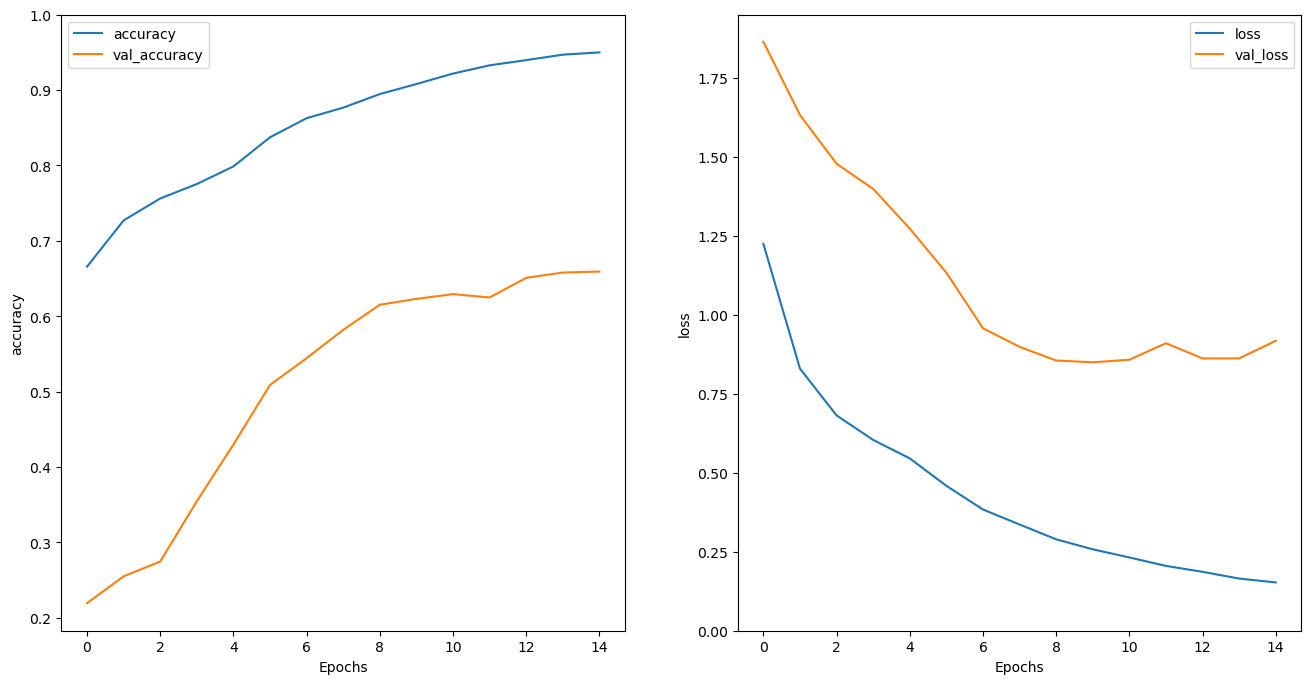

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)